<a href="https://colab.research.google.com/github/MengOonLee/Deep_learning/blob/master/TensorFlow/Probabilistic/Bijectors/Bijectors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpl = tfp.layers

# Bijectors and normalising flows

 ## Coding tutorials
 #### [1. Bijectors](#coding_tutorial_1)
 #### [2. The TransformedDistribution class](#coding_tutorial_2)
 #### [3. Subclassing bijectors](#coding_tutorial_3)
 #### [4. Normalising flows](#coding_tutorial_4)

***
<a id="coding_tutorial_1"></a>
## Bijectors

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
tf.keras.utils.set_random_seed(seed=42)

normal = tfp.distributions.Normal(loc=0., scale=1.)
z = normal.sample(sample_shape=3)

scale_and_shift = tfp.bijectors.Chain(bijectors=[
    tfp.bijectors.Shift(shift=1.),
    tfp.bijectors.Scale(scale=2.)
])

x = scale_and_shift.forward(x=z)
print('x:', x)
z = scale_and_shift.inverse(y=x)
print('z:', z)

log_prob_x = normal.log_prob(value=z)\
    - scale_and_shift.forward_log_det_jacobian(x=z, event_ndims=0)
print('log_prob x:', log_prob_x)

x: tf.Tensor([ 1.654937  -0.6852516  1.6388674], shape=(3,), dtype=float32)
z: tf.Tensor([ 0.3274685 -0.8426258  0.3194337], shape=(3,), dtype=float32)
log_prob x: tf.Tensor([-1.6657035 -1.9670948 -1.6631047], shape=(3,), dtype=float32)


In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
tf.keras.utils.set_random_seed(seed=42)

# Define base distribution

normal = tfp.distributions.Normal(loc=0., scale=1.)
normal

<tfp.distributions.Normal 'Normal' batch_shape=[] event_shape=[] dtype=float32>

In [ ]:
# Sample from base distribution

n = 10000
z = normal.sample(sample_shape=n)
z.shape

TensorShape([10000])

### Scale and shift bijector

In [ ]:
# Define scale and shift

scale = 4.5
shift = 7.

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
tf.keras.utils.set_random_seed(seed=42)

# Define chain bijector

scale_and_shift = tfp.bijectors.Chain(bijectors=[
    tfp.bijectors.Shift(shift=shift),
    tfp.bijectors.Scale(scale=scale)
])
scale_and_shift

<tfp.bijectors.Chain 'chain_of_shift_of_scale' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=float32 dtype_y=float32 bijectors=[<tfp.bijectors.Shift 'shift' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=float32 dtype_y=float32>, <tfp.bijectors.Scale 'scale' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=float32 dtype_y=float32>]>

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
tf.keras.utils.set_random_seed(seed=42)

# We can also use call methods

scale_transf = tfp.bijectors.Scale(scale=scale)
shift_transf = tfp.bijectors.Shift(shift=shift)
scale_and_shift = shift_transf(scale_transf)
scale_and_shift

<tfp.bijectors.Chain 'chain_of_shift_of_scale' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=float32 dtype_y=float32 bijectors=[<tfp.bijectors.Shift 'shift' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=float32 dtype_y=float32>, <tfp.bijectors.Scale 'scale' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=float32 dtype_y=float32>]>

In [ ]:
# Apply the forward transformation

x = scale_and_shift.forward(x=z)
x.shape

TensorShape([10000])

In [ ]:
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)

# Check the forward transformation

tf.norm(tensor=x-(scale*z+shift))

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

#### Plots

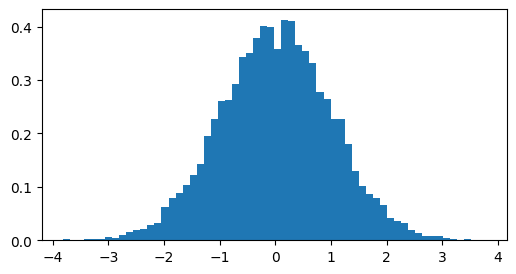

In [ ]:
import matplotlib.pyplot as plt

# Plot z density

plt.figure(figsize=(6, 3))
plt.hist(x=z, bins=60, density=True)
plt.show()

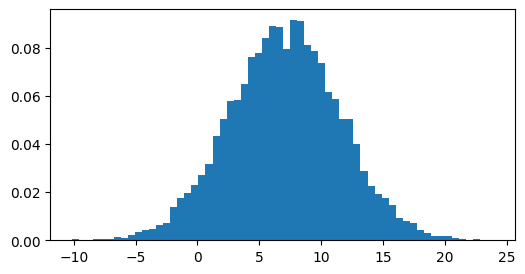

In [ ]:
import matplotlib.pyplot as plt

# Plot x density

plt.figure(figsize=(6, 3))
plt.hist(x=x, bins=60, density=True)
plt.show()

#### Inverse transformation

In [ ]:
# Apply inverse transformation

inv_x = scale_and_shift.inverse(y=x)
inv_x.shape

TensorShape([10000])

In [ ]:
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)

# Check inverse transformation

tf.norm(tensor=inv_x-z)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

#### Log probability

In [ ]:
# Compute log prob for x

log_prob_x = normal.log_prob(value=z)\
    - scale_and_shift.forward_log_det_jacobian(x=z, event_ndims=0)
log_prob_x

<tf.Tensor: shape=(10000,), dtype=float32, numpy=
array([-2.4766338, -2.7780252, -2.4740348, ..., -2.448865 , -4.363263 ,
       -5.6196175], dtype=float32)>

In [ ]:
# We can also use the inverse transformation

log_prob_x = normal.log_prob(value=scale_and_shift.inverse(y=x))\
    + scale_and_shift.inverse_log_det_jacobian(y=x, event_ndims=0)
log_prob_x

<tf.Tensor: shape=(10000,), dtype=float32, numpy=
array([-2.4766338, -2.7780252, -2.4740348, ..., -2.448865 , -4.363263 ,
       -5.6196175], dtype=float32)>

### Broadcasting

In [1]:
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)

x = tf.random.normal(shape=[100, 1])
x.shape

TensorShape([100, 1])

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
tf.keras.utils.set_random_seed(seed=42)

# Softfloor bijector

softfloor = tfp.bijectors.Softfloor(temperature=0.01)
y = softfloor.forward(x=x)
y.shape

TensorShape([100, 1])

In [3]:
import tensorflow as tf
import tensorflow_probability as tfp
tf.keras.utils.set_random_seed(seed=42)

# Softfloor bijector using broadcasting

softfloor = tfp.bijectors.Softfloor(temperature=[0.2, 1.])
y = softfloor.forward(x=x)
y.shape

TensorShape([100, 2])

In [4]:
import tensorflow as tf
import tensorflow_probability as tfp
tf.keras.utils.set_random_seed(seed=42)

# Softfloor bijector using broadcasting

softfloor = tfp.bijectors.Softfloor(temperature=[0.01, 0.1, 1.])
y = softfloor.forward(x=x)
y.shape

TensorShape([100, 3])

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Plot routine
def _plot(nparams, bijector, params, x):
    bijector_params = tuple(getattr(bijector, name) for name in params)
    upper_params = [name[0].upper() + name[1:] for name in params]
    plt.figure(figsize=(9, 3))
    lines = plt.plot(np.tile(A=x, reps=nparams), bijector.forward(x=x))
    for l in zip(lines, *bijector_params):
        labels = ': {:.2f}, '.join(upper_params) + ': {:.2f}'
        l[0].set_label(labels.format(*l[1:]))
    plt.legend()
    plt.show()

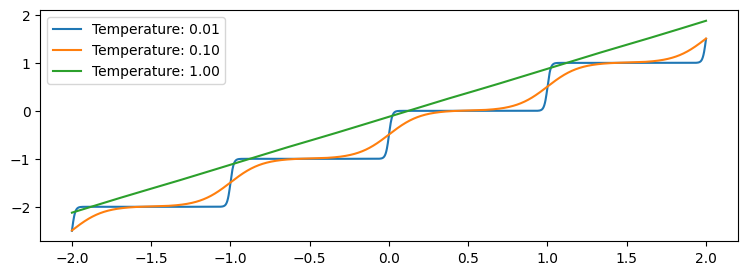

In [6]:
import numpy as np

# Plot
x = np.linspace(start=-2., stop=2., num=2000, dtype=np.float32)
_plot(nparams=3, bijector=softfloor, params=['temperature'], x=x[..., np.newaxis])

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
tf.keras.utils.set_random_seed(seed=42)

# Gumbel bijector using broadcasting

exps = tfp.bijectors.GumbelCDF(loc=[0.5, 1., 1.5, 2., 3.],
    scale=[1., 2., 2., 3., 4.])
exps

<tfp.bijectors.GumbelCDF 'gumbel_cdf' batch_shape=[5] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>

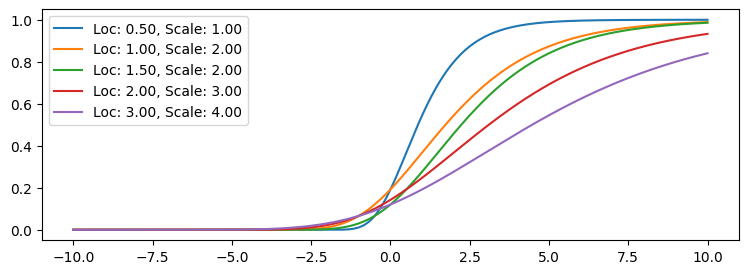

In [ ]:
import numpy as np

# Plot
x = np.linspace(start=-10., stop=10., num=2000,
    dtype=np.float32)
_plot(nparams=5, bijector=exps, params=['loc', 'scale'], x=x[..., np.newaxis])

***
<a id="coding_tutorial_2"></a>
## The TransformedDistribution class

### TransformedDistribution

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
tf.keras.utils.set_random_seed(seed=42)

# Base dist.        Transformation        Data dist.
# Z ~ P0      <=>      x = f(z)     <=>    x ~ P1

# log_prob_x = base_dist.log_prob(bijector.inverse(y=x))
#     + bijector.inverse_log_det_jacobian(y=x, event_ndims=0)
# x_sample = bijector.forward(x=base_dist.sample())

normal = tfp.distributions.Normal(loc=0., scale=1.)
z = normal.sample(sample_shape=3)

bijector = tfp.bijectors.Chain(bijectors=[
    tfp.bijectors.Shift(shift=1.),
    tfp.bijectors.Exp()
])
x = bijector.forward(x=z)

log_prob_x = normal.log_prob(value=z) - bijector.forward_log_det_jacobian(
    x=z, event_ndims=0)
print(log_prob_x)

log_prob_x = normal.log_prob(value=bijector.inverse(y=x))\
    + bijector.inverse_log_det_jacobian(y=x, event_ndims=0)
print(log_prob_x)

transform_distrib = tfp.distributions.TransformedDistribution(
    distribution=normal, bijector=bijector)
log_prob_x = transform_distrib.log_prob(value=x)
print(log_prob_x)

tf.Tensor([-1.3000249 -0.4313218 -1.2893912], shape=(3,), dtype=float32)
tf.Tensor([-1.3000249 -0.4313218 -1.2893912], shape=(3,), dtype=float32)
tf.Tensor([-1.3000249 -0.4313218 -1.2893912], shape=(3,), dtype=float32)


In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
tf.keras.utils.set_random_seed(seed=42)

normal = tfp.distributions.Normal(loc=0., scale=1.)
print('base dist:', normal)

scale_tril = [
    [[1., 0.], [1., 1.]],
    [[0.5, 0.], [-1., 0.5]],
    [[1., 0.5], [-0.5, 1.]]
] # (3, 2, 2)
bijector = tfp.bijectors.ScaleMatvecTriL(scale_tril=scale_tril)

transform_distrib = tfp.distributions.TransformedDistribution(
    distribution=tfp.distributions.Sample(distribution=normal, sample_shape=2),
    bijector=bijector)
print('transform dist:', transform_distrib)

mvn = tfp.distributions.MultivariateNormalTriL(loc=0., scale_tril=scale_tril)
print('multivariate dist:', mvn)

base dist: tfp.distributions.Normal("Normal", batch_shape=[], event_shape=[], dtype=float32)
transform dist: tfp.distributions.TransformedDistribution("scale_matvec_trilSampleNormal", batch_shape=[3], event_shape=[2], dtype=float32)
multivariate dist: tfp.distributions.MultivariateNormalTriL("MultivariateNormalTriL", batch_shape=[3], event_shape=[2], dtype=float32)


In [ ]:
# Parameters

n = 10000
loc = 0.
scale = 0.5

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
tf.keras.utils.set_random_seed(seed=42)

# Normal distribution
loc = 0.
scale = 0.5
normal = tfp.distributions.Normal(loc=loc, scale=scale)
normal

<tfp.distributions.Normal 'Normal' batch_shape=[] event_shape=[] dtype=float32>

In [ ]:
# Display event and batch shape

print('batch shape: ', normal.batch_shape)
print('event shape: ', normal.event_shape)

batch shape:  ()
event shape:  ()


In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
tf.keras.utils.set_random_seed(seed=42)

# Exponential bijector

exp = tfp.bijectors.Exp()
exp

<tfp.bijectors.Exp 'exp' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
tf.keras.utils.set_random_seed(seed=42)

# Log normal transformed distribution using exp and normal bijectors

log_normal_td = tfp.distributions.TransformedDistribution(
    distribution=normal, bijector=exp)
log_normal_td

<tfp.distributions.TransformedDistribution 'expNormal' batch_shape=[] event_shape=[] dtype=float32>

In [ ]:
# Display event and batch shape

print('batch shape: ', log_normal_td.batch_shape)
print('event shape: ', log_normal_td.event_shape)

batch shape:  ()
event shape:  ()


In [ ]:
# Base distribution

n = 10000
z = normal.sample(sample_shape=n)
z.shape

TensorShape([10000])

#### Plots

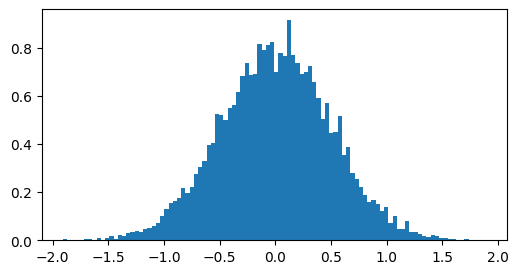

In [ ]:
import matplotlib.pyplot as plt

# Plot z density

plt.figure(figsize=(6, 3))
plt.hist(x=z, bins=100, density=True)
plt.show()

In [ ]:
# Transformed distribution

n = 10000
x = log_normal_td.sample(sample_shape=n)
x.shape

TensorShape([10000])

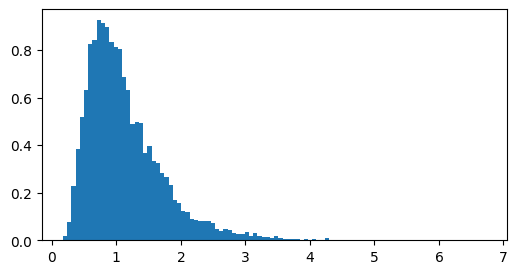

In [ ]:
import matplotlib.pyplot as plt

# Plot x density

plt.figure(figsize=(6, 3))
plt.hist(x=x, bins=100, density=True)
plt.show()

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
tf.keras.utils.set_random_seed(seed=42)

# Define log normal distribution

loc = 0.
scale = 0.5
log_normal = tfp.distributions.LogNormal(loc=loc, scale=scale)
log_normal

<tfp.distributions.LogNormal 'LogNormal' batch_shape=[] event_shape=[] dtype=float32>

In [ ]:
# Sample log_normal

n = 10000
l = log_normal.sample(sample_shape=n)
l.shape

TensorShape([10000])

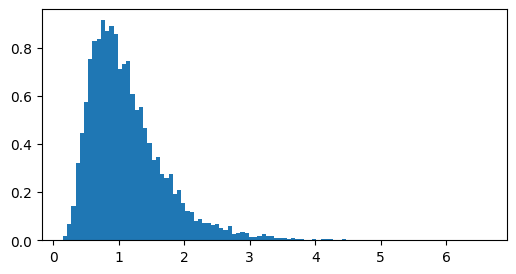

In [ ]:
import matplotlib.pyplot as plt

# Plot l density

plt.figure(figsize=(6, 3))
plt.hist(x=l, bins=100, density=True)
plt.show()

#### Log probability

In [ ]:
# Log prob of LogNormal

log_prob = log_normal.log_prob(value=x)
log_prob.shape

TensorShape([10000])

In [ ]:
# Log prob of log normal transformed distribution

log_prob_td = log_normal_td.log_prob(value=x)
log_prob_td.shape

TensorShape([10000])

In [ ]:
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)

# Check log probs

tf.norm(tensor=(log_prob-log_prob_td))

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

### Event shape and batch shape

In [ ]:
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)

# Set a scaling lower triangular matrix

tril = tf.random.normal(shape=(2, 4, 4))
scale_low_tril = tf.linalg.LinearOperatorLowerTriangular(tril=tril)
scale_low_tril

In [ ]:
# View of scale_low_tri

scale_low_tril.to_dense()

<tf.Tensor: shape=(2, 4, 4), dtype=float32, numpy=
array([[[ 0.3274685 ,  0.        ,  0.        ,  0.        ],
        [-2.3880599 , -1.0392479 ,  0.        ,  0.        ],
        [ 1.6994323 ,  0.28893656, -1.5066116 ,  0.        ],
        [-0.59722406, -1.9171132 , -0.62044144,  0.8504023 ]],

       [[-0.40604794,  0.        ,  0.        ,  0.        ],
        [-0.22561555, -0.7616443 ,  0.        ,  0.        ],
        [ 0.77852213, -0.47338897,  0.97772694,  0.        ],
        [ 0.20573747, -0.5256233 ,  0.32410017,  0.02545409]]],
      dtype=float32)>

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
tf.keras.utils.set_random_seed(seed=42)

# Define scale linear operator

scale_lin_op = tfp.bijectors.ScaleMatvecLinearOperator(scale=scale_low_tril)
scale_lin_op

<tfp.bijectors.ScaleMatvecLinearOperator 'scale_matvec_linear_operator' batch_shape=[2] forward_min_event_ndims=1 inverse_min_event_ndims=1 dtype_x=float32 dtype_y=float32>

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
tf.keras.utils.set_random_seed(seed=42)

# Define scale linear operator transformed distribution with a batch and event shape

normal = tfp.distributions.Normal(loc=0., scale=0.5)

mvn1 = tfp.distributions.TransformedDistribution(
    distribution=tfp.distributions.Sample(distribution=normal, sample_shape=4),
    bijector=scale_lin_op)
mvn1

<tfp.distributions.TransformedDistribution 'scale_matvec_linear_operatorSampleNormal' batch_shape=[2] event_shape=[4] dtype=float32>

In [ ]:
# Display event and batch shape

print('batch shape: ', mvn1.batch_shape)
print('event shape: ', mvn1.event_shape)

batch shape:  (2,)
event shape:  (4,)


In [ ]:
# Sample

n = 10000
y1 = mvn1.sample(sample_shape=n)
y1.shape

TensorShape([10000, 2, 4])

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
tf.keras.utils.set_random_seed(seed=42)

# Define a MultivariateNormalLinearOperator distribution
mvn2 = tfp.distributions.MultivariateNormalLinearOperator(loc=0.,
    scale=scale_low_tril)
mvn2

<tfp.distributions.MultivariateNormalLinearOperator 'MultivariateNormalLinearOperator' batch_shape=[2] event_shape=[4] dtype=float32>

In [ ]:
# Display event and batch shape
print('batch shape: ', mvn2.batch_shape)
print('event shape: ', mvn2.event_shape)

batch shape:  (2,)
event shape:  (4,)


In [ ]:
# Sample
n = 10000
y2 = mvn2.sample(sample_shape=n)
y2.shape

TensorShape([10000, 2, 4])

In [ ]:
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)

# Check
n = 10000
xn = normal.sample(sample_shape=(n, 2, 4))
tf.norm(tensor=(mvn1.log_prob(value=xn) - mvn2.log_prob(value=xn)))\
    / tf.norm(tensor=mvn1.log_prob(value=xn))

<tf.Tensor: shape=(), dtype=float32, numpy=0.7499715089797974>

***
<a id="coding_tutorial_3"></a>
## Subclassing bijectors

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
tf.keras.utils.set_random_seed(seed=42)

class MySigmoid(tfp.bijectors.Bijector):
    def __init__(self, validate_args=False, name='sigmoid'):
        super().__init__(validate_args=validate_args,
            forward_min_event_ndims=0, name=name)

    def _forward(self, x):
        return tf.math.sigmoid(x=x)

    def _inverse(self, y):
        return tf.math.log(x=y) - tf.math.log(x=(1 - y))

    def _inverse_log_det_jacobian(self, y):
        return -tf.math.log(x=y) - tf.math.log(x=(1 - y))

    def _forward_log_det_jacobian(self, x):
        return -self._inverse_log_det_jacobian(y=self._forward(x=x))

class MyShift(tfp.bijectors.Bijector):
    def __init__(self, shift, validate_args=False, name='shift'):
        super().__init__(validate_args=validate_args,
            forward_min_event_ndims=0, name=name,
            is_constant_jacobian=True)
        self.shift = shift

    def _forward(self, x):
        return x + self.shift

    def _inverse(self, y):
        return y - self.shift

    def _forward_log_det_jacobian(self, x):
        return tf.constant(value=0., dtype=x.dtype)

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
tf.keras.utils.set_random_seed(seed=42)

# Define a new bijector: Cubic

class Cubic(tfp.bijectors.Bijector):
    def __init__(self, a, b, validate_args=False, name='Cubic'):
        self.a = tf.cast(x=a, dtype=tf.float32)
        self.b = tf.cast(x=b, dtype=tf.float32)
        if validate_args:
            assert tf.math.reduce_mean(input_tensor=tf.cast(
                x=tf.math.greater_equal(x=tf.math.abs(x=self.a),
                y=1e-5), dtype=tf.float32))==1.0
            assert tf.math.reduce_mean(input_tensor=tf.cast(
                x=tf.math.greater_equal(x=tf.math.abs(x=self.b),
                y=1e-5), dtype=tf.float32))==1.0
        super().__init__(validate_args=validate_args,
            forward_min_event_ndims=0, name=name)

    def _forward(self, x):
        x = tf.cast(x=x, dtype=tf.float32)
        return tf.squeeze(input=tf.math.pow(x=self.a * x + self.b, y=3))

    def _inverse(self, y):
        y = tf.cast(x=y, dtype=tf.float32)
        return (tf.math.sign(x=y) * tf.math.pow(x=tf.math.abs(x=y), y=1/3)
            - self.b) / self.a

    def _forward_log_det_jacobian(self, x):
        x = tf.cast(x=x, dtype=tf.float32)
        return tf.math.log(x=3. * tf.math.abs(x=self.a))\
            + 2. * tf.math.log(x=tf.math.abs(x=self.a * x + self.b))

In [ ]:
# Cubic bijector
cubic = Cubic(a=[1., -2.], b=[-1., 0.4], validate_args=True)
cubic

<tfp.bijectors.Cubic 'Cubic' batch_shape=? forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>

In [ ]:
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)

# Apply forward transformation
x = tf.constant(value=[[1., 2.], [3., 4.]], dtype=tf.float32)
y = cubic.forward(x=x)
y

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[   0.      ,  -46.655994],
       [   8.      , -438.97598 ]], dtype=float32)>

In [ ]:
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)

# Check inverse
tf.norm(tensor=(x - cubic.inverse(y=y)))

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

#### Function plots

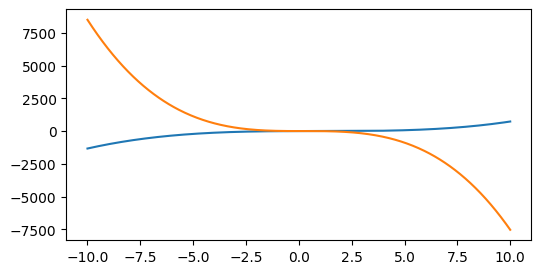

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(seed=42)

# Plot the forward transformation
x = np.linspace(start=-10, stop=10, num=500).reshape(-1, 1)
plt.figure(figsize=(6, 3))
plt.plot(x, cubic.forward(x=x))
plt.show()

In [ ]:
# Display shape
cubic.forward(x=x).shape

TensorShape([500, 2])

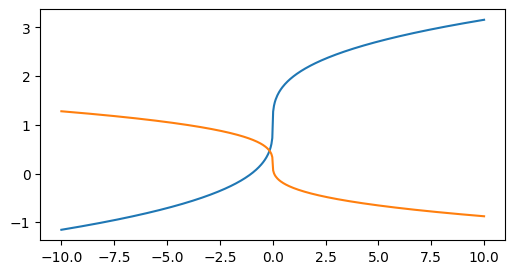

In [ ]:
import matplotlib.pyplot as plt

# Plot the inverse
plt.figure(figsize=(6, 3))
plt.plot(x, cubic.inverse(y=x))
plt.show()

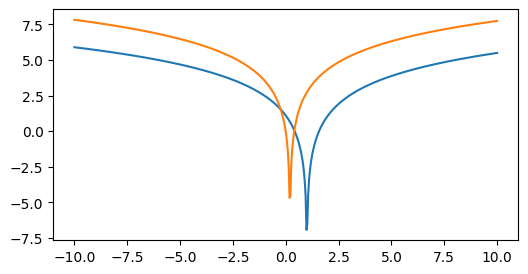

In [ ]:
import matplotlib.pyplot as plt

# Plot the forward log Jacobian determinant
plt.figure(figsize=(6, 3))
plt.plot(x, cubic.forward_log_det_jacobian(x=x, event_ndims=0))
plt.show()

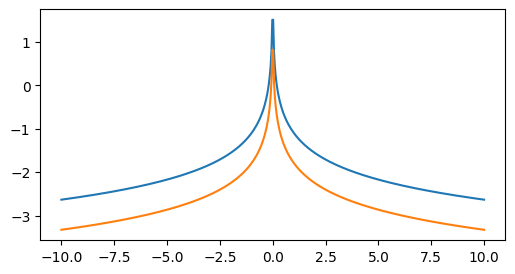

In [ ]:
import matplotlib.pyplot as plt

# Plot the inverse log Jacobian determinant
plt.figure(figsize=(6, 3))
plt.plot(x, cubic.inverse_log_det_jacobian(y=x, event_ndims=0))
plt.show()

#### TransformedDistribution and plots

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
tf.keras.utils.set_random_seed(seed=42)

# Create a transformed distribution with Cubic
normal = tfp.distributions.Normal(loc=0., scale=1.)
cubed_normal = tfp.distributions.TransformedDistribution(
    distribution=tfp.distributions.Sample(distribution=normal, sample_shape=2),
    bijector=cubic)
cubed_normal

<tfp.distributions._TransformedDistribution 'CubicSampleNormal' batch_shape=[] event_shape=[2] dtype=float32>

In [ ]:
# Sample cubed_normal
n = 1000
g = cubed_normal.sample(sample_shape=n)
g.shape

TensorShape([1000, 2])

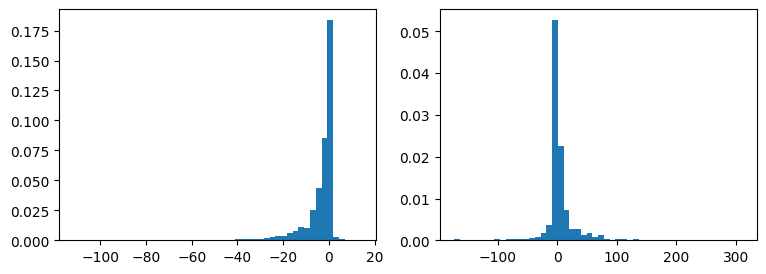

In [ ]:
import matplotlib.pyplot as plt

# Plot histograms
plt.figure(figsize=(9, 3))
plt.subplot(1, 2, 1)
plt.hist(x=g[..., 0], bins=50, density=True)
plt.subplot(1, 2, 2)
plt.hist(x=g[..., 1], bins=50, density=True)
plt.show()

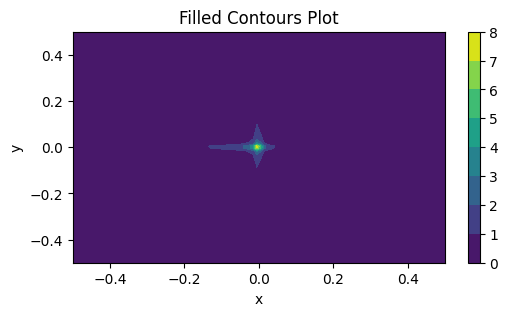

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(seed=42)

# Make contour plot
xx = np.linspace(start=-0.5, stop=0.5, num=100)
yy = np.linspace(start=-0.5, stop=0.5, num=100)
X, Y = np.meshgrid(xx, yy)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 3))
Z = cubed_normal.prob(value=np.dstack(tup=(X, Y)))
cp = ax.contourf(X, Y, Z)
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title(label='Filled Contours Plot')
ax.set_xlabel(xlabel='x')
ax.set_ylabel(ylabel='y')
fig.show()

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
tf.keras.utils.set_random_seed(seed=42)

# Create a transformed distribution with the inverse of Cube
normal = tfp.distributions.Normal(loc=0., scale=1.)
inverse_cubic = tfp.bijectors.Invert(bijector=cubic)
inv_cubed_normal = tfp.distributions.TransformedDistribution(
    distribution=tfp.distributions.Sample(distribution=normal, sample_shape=2),
    bijector=inverse_cubic)
inv_cubed_normal

<tfp.distributions._TransformedDistribution 'invert_CubicSampleNormal' batch_shape=[] event_shape=[2] dtype=float32>

In [ ]:
# Samble inv_cubed_normal
n = 1000
g = inv_cubed_normal.sample(sample_shape=n)
g.shape

TensorShape([1000, 2])

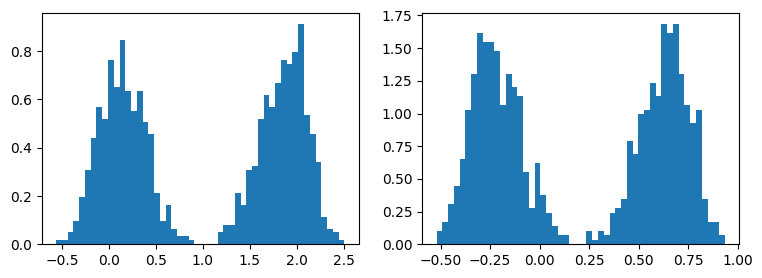

In [ ]:
import matplotlib.pyplot as plt

# Plot histograms
plt.figure(figsize=(9, 3))
plt.subplot(1, 2, 1)
plt.hist(x=g[..., 0], bins=50, density=True)
plt.subplot(1, 2, 2)
plt.hist(x=g[..., 1], bins=50, density=True)
plt.show()

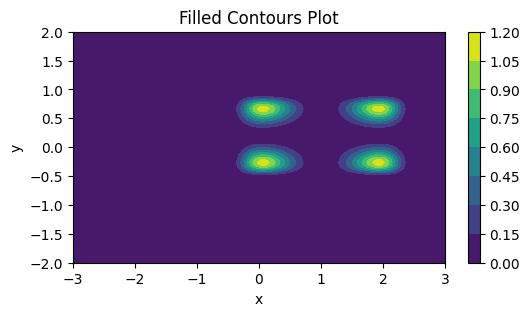

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(seed=42)

# Make contour plot
xx = np.linspace(start=-3.0, stop=3.0, num=100)
yy = np.linspace(start=-2.0, stop=2.0, num=100)
X, Y = np.meshgrid(xx, yy)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 3))
Z = inv_cubed_normal.prob(value=np.dstack(tup=(X, Y)))
cp = ax.contourf(X, Y, Z)
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title(label='Filled Contours Plot')
ax.set_xlabel(xlabel='x')
ax.set_ylabel(ylabel='y')
fig.show()

#### Training the bijector

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
tf.keras.utils.set_random_seed(seed=42)

# Create a mixture of four Gaussians
probs = [0.45, 0.55]
mix_gauss = tfp.distributions.Mixture(
    cat=tfp.distributions.Categorical(probs=probs),
    components=[
        tfp.distributions.Normal(loc=2.3, scale=0.4),
        tfp.distributions.Normal(loc=-0.8, scale=0.4)
    ]
)
mix_gauss

<tfp.distributions.Mixture 'Mixture' batch_shape=[] event_shape=[] dtype=float32>

In [ ]:
import tensorflow as tf

# Create the dataset
x_train = mix_gauss.sample(sample_shape=10000)
x_train = tf.data.Dataset.from_tensor_slices(tensors=x_train)
x_train = x_train.batch(batch_size=128)
print(x_train.element_spec)

x_valid = mix_gauss.sample(sample_shape=1000)
x_valid = tf.data.Dataset.from_tensor_slices(tensors=x_valid)
x_valid = x_valid.batch(batch_size=128)
print(x_valid.element_spec)

TensorSpec(shape=(None,), dtype=tf.float32, name=None)
TensorSpec(shape=(None,), dtype=tf.float32, name=None)


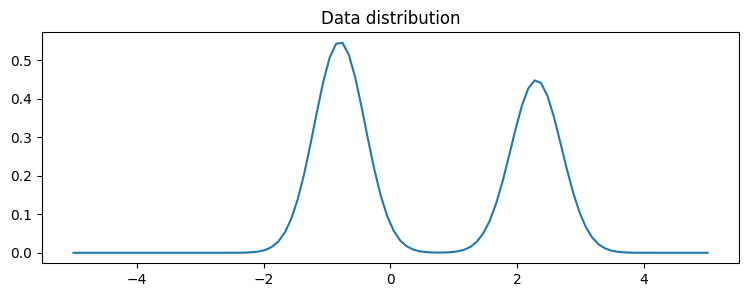

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(seed=42)

# Plot the data distribution
x = np.linspace(start=-5.0, stop=5.0, num=100)
plt.figure(figsize=(9, 3))
plt.plot(x, mix_gauss.prob(value=x))
plt.title(label='Data distribution')
plt.show()

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
tf.keras.utils.set_random_seed(seed=42)

# Make a trainable bijector
trainable_inv_cubic = tfp.bijectors.Invert(bijector=Cubic(
    a=tf.Variable(initial_value=0.25),
    b=tf.Variable(initial_value=-0.1)
))
trainable_inv_cubic.trainable_variables

(<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.25>,
 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=-0.10000000149011612>)

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
tf.keras.utils.set_random_seed(seed=42)

# Make a trainable transformed distribution
normal = tfp.distributions.Normal(loc=0., scale=1.)
trainable_dist = tfp.distributions.TransformedDistribution(
    distribution=normal, bijector=trainable_inv_cubic)
trainable_dist

<tfp.distributions._TransformedDistribution 'invert_CubicNormal' batch_shape=[] event_shape=[] dtype=float32>

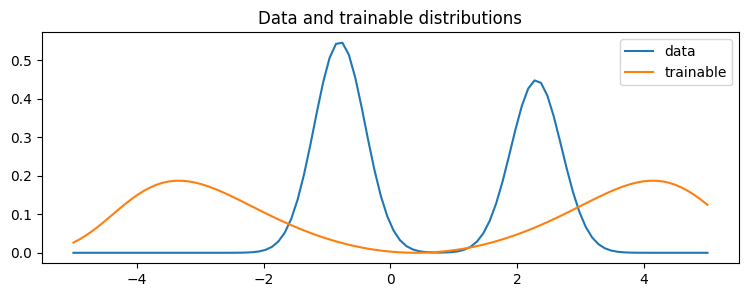

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(seed=42)

# Plot the data and learned distributions
x = np.linspace(start=-5.0, stop=5.0, num=100)
plt.figure(figsize=(9, 3))
plt.plot(x, mix_gauss.prob(value=x), label='data')
plt.plot(x, trainable_dist.prob(value=x), label='trainable')
plt.title(label='Data and trainable distributions')
plt.legend()
plt.show()

In [ ]:
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)

# Train the bijector
@tf.function
def get_loss_and_grads(x_train, distribution, bijector):
    with tf.GradientTape() as tape:
        tape.watch(tensor=bijector.trainable_variables)
        loss = -distribution.log_prob(value=x_train)
        grads = tape.gradient(target=loss,
            sources=bijector.trainable_variables)
    return loss, grads

num_epochs = 31
opt = tf.keras.optimizers.Adam()
train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    train_loss = tf.keras.metrics.Mean()
    val_loss = tf.keras.metrics.Mean()
    for train_batch in x_train:
        loss, grads = get_loss_and_grads(x_train=train_batch,
            distribution=trainable_dist, bijector=trainable_inv_cubic)
        train_loss(loss)
        opt.apply_gradients(grads_and_vars=zip(
            grads, trainable_inv_cubic.trainable_variables))
    train_losses.append(train_loss.result())

    # Validation
    for valid_batch in x_valid:
        loss = -trainable_dist.log_prob(value=valid_batch)
        val_loss(loss)
    valid_losses.append(val_loss.result())

    if epoch%10==0:
        print("Epoch {}, Loss: train={}, valid={}".format(epoch,
            train_loss.result(), val_loss.result()))

Epoch 0, Loss: train=2.8778600692749023, valid=2.453965187072754
Epoch 10, Loss: train=1.4680508375167847, valid=1.4012320041656494
Epoch 20, Loss: train=1.2593973875045776, valid=1.238555908203125
Epoch 30, Loss: train=1.2358814477920532, valid=1.2307629585266113


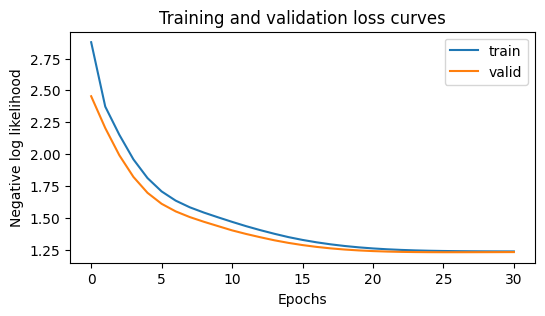

In [ ]:
import matplotlib.pyplot as plt

# Plot the learning curves
plt.figure(figsize=(6, 3))
plt.plot(train_losses, label='train')
plt.plot(valid_losses, label='valid')
plt.legend()
plt.xlabel(xlabel='Epochs')
plt.ylabel(ylabel='Negative log likelihood')
plt.title(label='Training and validation loss curves')
plt.show()

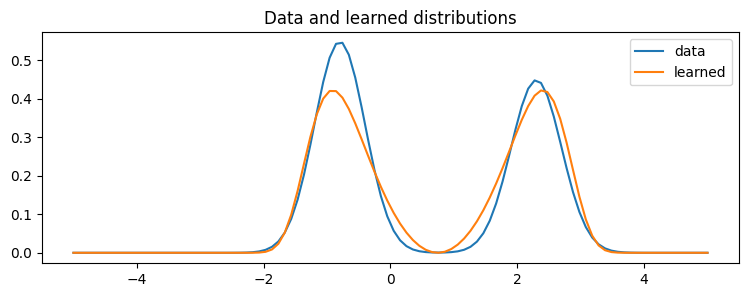

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(seed=42)

# Plot the data and learned distributions
x = np.linspace(start=-5.0, stop=5.0, num=100)
plt.figure(figsize=(9, 3))
plt.plot(x, mix_gauss.prob(value=x), label='data')
plt.plot(x, trainable_dist.prob(value=x), label='learned')
plt.title(label='Data and learned distributions')
plt.legend()
plt.show()

In [ ]:
# Display trainable variables
trainable_inv_cubic.trainable_variables

(<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.5638839602470398>,
 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=-0.4207334816455841>)

***
<a id="coding_tutorial_4"></a>
## Normalising flows

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
tf.keras.utils.set_random_seed(seed=42)

# z ~ N(0, I)
# x[i] = z[i] * scale(x[0:i-1]) + loc(x[0:i-1]), i=0,...,D-1

made = tfp.bijectors.AutoregressiveNetwork(params=2, event_shape=3,
    hidden_units=[16, 16], activation=tf.keras.activations.sigmoid)
print('Output made shape:', made(x=tf.random.normal(shape=[10, 3])).shape)

maf_bijector = tfp.bijectors.MaskedAutoregressiveFlow(shift_and_log_scale_fn=made)

def forward(z):
    x = tf.zeros_like(input=z)
    for _ in range(D):
        shift, log_scale = shift_and_log_scale_fn(x)
        x = z * tf.math.exp(x=log_scale) + shift
    return x

def inverse(x):
    shift, log_scale = shift_and_log_scale_fn(x)
    return (x - shift) / tf.math.exp(x=log_scale)

normal = tfp.distributions.Normal(loc=0., scale=1.)
maf = tfp.distributions.TransformedDistribution(bijector=maf_bijector,
    distribution=tfp.distributions.Sample(distribution=normal, sample_shape=3))
maf

Output made shape: (10, 3, 2)


<tfp.distributions._TransformedDistribution 'masked_autoregressive_flowSampleNormal' batch_shape=[] event_shape=[3] dtype=float32>

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
tf.keras.utils.set_random_seed(seed=42)

# z ~ N(0, I)
# x[i] = z[i] + loc(x[0:i-1]), i=0,...,D-1

made = tfp.bijectors.AutoregressiveNetwork(params=2, event_shape=3,
    hidden_units=[16, 16], activation=tf.keras.activations.sigmoid)

maf_bijector = tfp.bijectors.MaskedAutoregressiveFlow(
    shift_and_log_scale_fn=lambda y: (made(x=y)[..., 0], None),
    is_constant_jacobian=True)
maf_bijector._made = made

normal = tfp.distributions.Normal(loc=0., scale=1.)
maf = tfp.distributions.TransformedDistribution(
    distribution=tfp.distributions.Sample(distribution=normal, sample_shape=3),
    bijector=maf_bijector)
maf

<tfp.distributions._TransformedDistribution 'masked_autoregressive_flowSampleNormal' batch_shape=[] event_shape=[3] dtype=float32>

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
tf.keras.utils.set_random_seed(seed=42)

# z ~ N(0, I)
# z[i] = (x[i] - loc(x[0:i-1])) / scale(x[0:i-1]), i=0,...,D-1

made = tfp.bijectors.AutoregressiveNetwork(params=2, event_shape=3,
    hidden_units=[16, 16], activation=tf.keras.activations.sigmoid)

iaf_bijector = tfp.bijectors.Invert(bijector=
    tfp.bijectors.MaskedAutoregressiveFlow(shift_and_log_scale_fn=made))

normal = tfp.distributions.Normal(loc=0., scale=1.)
iaf = tfp.distributions.TransformedDistribution(
    distribution=tfp.distributions.Sample(distribution=normal, sample_shape=3),
    bijector=iaf_bijector)
iaf

<tfp.distributions._TransformedDistribution 'invert_masked_autoregressive_flowSampleNormal' batch_shape=[] event_shape=[3] dtype=float32>

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
tf.keras.utils.set_random_seed(seed=42)

# z ~ N(0, I)
# x[0:d] = z[0:d]
# x[d:D] = z[d:D]*scale(z[0:d]) + loc(z[0:d])

shift_and_log_scale_fn = tfp.bijectors.real_nvp_default_template(
    hidden_layers=[32, 32], activation=tf.nn.relu, shift_only=True)
print('shift only:', shift_and_log_scale_fn(x=tf.random.normal(shape=[3,]),
    output_units=1))

shift_and_log_scale_fn = tfp.bijectors.real_nvp_default_template(
    hidden_layers=(32, 32), activation=tf.nn.relu)
print('shift, log scale:', shift_and_log_scale_fn(x=tf.random.normal(shape=[3,]),
    output_units=1))

realnvp_bijector = tfp.bijectors.RealNVP(fraction_masked=0.5,
    shift_and_log_scale_fn=shift_and_log_scale_fn)

realnvp_bijector = tfp.bijectors.RealNVP(num_masked=2,
    shift_and_log_scale_fn=shift_and_log_scale_fn)

def forward(z):
    x = tf.zeros_like(input=z)
    x[0:d] = z[0:d]
    shift, log_scale = shift_and_log_scale_fn(x=z[0:d])
    x[d:D] = z[d:D]*tf.math.exp(x=log_scale) + shift
    return x

def inverse(x):
    z = tf.zeros_like(input=x)
    z[0:d] = x[0:d]
    shift, log_scale = shift_and_log_scale_fn(x=x[0:d])
    z[d:D] = (x[d:D] - shift)*tf.math.exp(x=-log_scale)
    return z

mvn = tfp.distributions.MultivariateNormalDiag(loc=[0., 0., 0.])
realnvp = tfp.distributions.TransformedDistribution(distribution=mvn,
    bijector=realnvp_bijector)
realnvp

shift only: (<tf.Tensor: shape=(1,), dtype=float32, numpy=array([-0.21562324], dtype=float32)>, None)
shift, log scale: (<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.1512907], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-0.02651986], dtype=float32)>)


<tfp.distributions._TransformedDistribution 'real_nvpMultivariateNormalDiag' batch_shape=[] event_shape=[3] dtype=float32>

In [15]:
import tensorflow as tf
import tensorflow_probability as tfp
tf.keras.utils.set_random_seed(seed=42)

permute = tfp.bijectors.Permute(permutation=[1, 2, 0])
realnvp1 = tfp.bijectors.RealNVP(fraction_masked=0.5, shift_and_log_scale_fn=
    tfp.bijectors.real_nvp_default_template(hidden_layers=[32, 32]))
realnvp2 = tfp.bijectors.RealNVP(fraction_masked=0.5, shift_and_log_scale_fn=
    tfp.bijectors.real_nvp_default_template(hidden_layers=[32, 32]))
realnvp3 = tfp.bijectors.RealNVP(fraction_masked=0.5, shift_and_log_scale_fn=
    tfp.bijectors.real_nvp_default_template(hidden_layers=[32, 32]))

chained_bijector = tfp.bijectors.Chain(bijectors=[
    realnvp3, permute, realnvp2, permute, realnvp1])

mvn = tfp.distributions.MultivariateNormalDiag(loc=[0., 0., 0.])
realnvp = tfp.distributions.TransformedDistribution(distribution=mvn,
    bijector=chained_bijector)
realnvp

<tfp.distributions._TransformedDistribution 'chain_of_real_nvp_of_permute_of_real_nvp_of_permute_of_real_nvpMultivariateNormalDiag' batch_shape=[] event_shape=[3] dtype=float32>

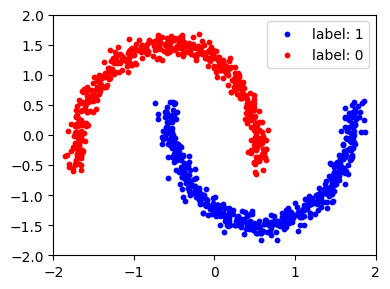

In [1]:
# Load dataset
from sklearn import datasets, preprocessing
import numpy as np
import matplotlib.pyplot as plt

n_samples = 1000
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05, random_state=42)
X, y = noisy_moons
X_data = preprocessing.StandardScaler().fit_transform(X=X)
y_label = y.astype(np.bool)
X0_train, X1_train = X_data[..., 0], X_data[..., 1]

# Plot with labels
plt.figure(figsize=[4, 3])
plt.scatter(x=X0_train[y_label], y=X1_train[y_label], s=10, color='blue')
plt.scatter(x=X0_train[y_label==False], y=X1_train[y_label==False], s=10, color='red')
plt.legend(['label: 1', 'label: 0'])
xlim, ylim = [-2, 2], [-2, 2]
plt.xlim(xlim)
plt.ylim(ylim)
plt.tight_layout()
plt.show()

In [2]:
# Define base distribution
import tensorflow as tf
import tensorflow_probability as tfp
tf.keras.utils.set_random_seed(seed=42)

base_distribution = tfp.distributions.Normal(loc=0., scale=1.)
base_distribution

<tfp.distributions.Normal 'Normal' batch_shape=[] event_shape=[] dtype=float32>

In [3]:
# Define the trainable distribution
import tensorflow as tf
import tensorflow_probability as tfp
tf.keras.utils.set_random_seed(seed=42)

def make_masked_autoregressive_flow(hidden_units=[16, 16],
    activation=tf.keras.activations.relu):
    made = tfp.bijectors.AutoregressiveNetwork(params=2, event_shape=2,
        hidden_units=hidden_units, activation=activation)
    return tfp.bijectors.MaskedAutoregressiveFlow(shift_and_log_scale_fn=made)

trainable_distribution = tfp.distributions.TransformedDistribution(
    distribution=tfp.distributions.Sample(distribution=base_distribution, sample_shape=2),
    bijector=make_masked_autoregressive_flow())
trainable_distribution

<tfp.distributions._TransformedDistribution 'masked_autoregressive_flowSampleNormal' batch_shape=[] event_shape=[2] dtype=float32>

In [4]:
# Define a plot contour routine
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import axes_grid1

def plot_contour_prob(dist, rows=1, title=[''], scale_fig=3):
    xx = np.linspace(start=-5.0, stop=5.0, num=100)
    yy = np.linspace(start=-5.0, stop=5.0, num=100)
    X, Y = np.meshgrid(xx, yy)
    cols = int(len(dist)/rows)
    fig, ax = plt.subplots(nrows=rows, ncols=cols,
        figsize=(scale_fig*cols, scale_fig*rows))
    fig.tight_layout(pad=4.5)

    i = 0
    for r in range(rows):
        for c in range(cols):
            Z = dist[i].prob(value=np.dstack(tup=(X, Y)))
            if len(dist) == 1:
                axi = ax
            elif rows == 1:
                axi = ax[c]
            else:
                axi = ax[r, c]

            # Plot contour
            p = axi.contourf(X, Y, Z)
            # Add a colorbar
            divider = axes_grid1.make_axes_locatable(axes=axi)
            cax = divider.append_axes(position="right", size="5%", pad=0.1)
            cbar = fig.colorbar(mappable=p, cax=cax)
            # Set title and labels
            axi.set_title(label='Filled Contours Plot: ' + str(title[i]))
            axi.set_xlabel(xlabel='x')
            axi.set_ylabel(ylabel='y')

            i += 1
    plt.show()

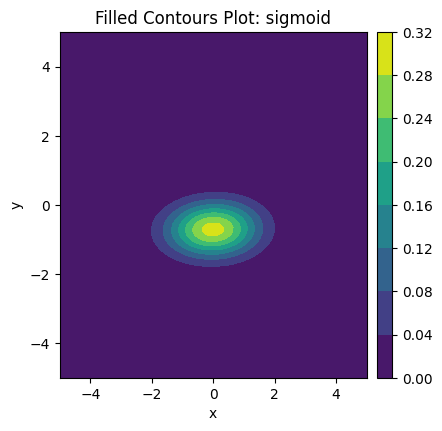

In [5]:
# Plot contour
import tensorflow as tf
import tensorflow_probability as tfp
tf.keras.utils.set_random_seed(seed=42)

maf = tfp.distributions.TransformedDistribution(
    distribution=tfp.distributions.Sample(distribution=base_distribution, sample_shape=2),
    bijector=make_masked_autoregressive_flow(activation=tf.keras.activations.sigmoid)
)
plot_contour_prob(dist=[maf], scale_fig=5, title=['sigmoid'])

In [6]:
# Make samples

x = base_distribution.sample(sample_shape=[1000, 2])
names = [base_distribution.name, trainable_distribution.bijector.name]
samples= [x, trainable_distribution.bijector.forward(x=x)]
names

['Normal', 'masked_autoregressive_flow']

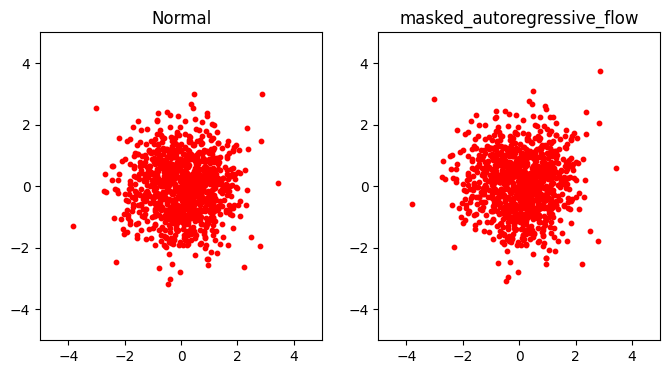

In [7]:
# Define a scatter plot routine for the bijectors
import matplotlib.pyplot as plt

def _plot(results, names, rows=1, legend=False):
    cols = int(len(results)/rows)
    f, arr = plt.subplots(nrows=rows, ncols=cols, figsize=(4*cols, 4*rows))
    i = 0
    for r in range(rows):
        for c in range(cols):
            res = results[i]
            X, Y = res[..., 0].numpy(), res[..., 1].numpy()
            if rows == 1:
                p = arr[c]
            else:
                p = arr[r, c]
            p.scatter(x=X, y=Y, s=10, color='red')
            p.set_xlim([-5, 5])
            p.set_ylim([-5, 5])
            p.set_title(label=names[i])

            i += 1

# Plot
_plot(results=samples, names=names)

#### Training a MaskedAutoregressiveFlow bijector

In [8]:
# Define a training routine
import numpy as np
import tf_keras
tf_keras.utils.set_random_seed(seed=42)

def train_dist_routine(trainable_distribution, n_epochs=200, batch_size=None, n_disp=100):
    tf_keras.utils.set_random_seed(seed=42)
    x_ = tf_keras.Input(shape=[2,], dtype=tf.float32)
    log_prob_ = trainable_distribution.log_prob(value=x_)
    model = tf_keras.Model(inputs=x_, outputs=log_prob_)

    model.compile(
        loss=lambda _, log_prob: -log_prob,
        optimizer=tf_keras.optimizers.Adam()
    )

    ns = X_data.shape[0]
    if batch_size is None:
        batch_size = ns

    # Display the loss every n_disp epoch
    epoch_callback = tf_keras.callbacks.LambdaCallback(on_epoch_end=
        lambda epoch, logs: print(
            '\n Epoch {}/{}'.format(epoch+1, n_epochs, logs),
            '\n\t ' + (': {:.4f}, '.join(logs.keys())
            + ': {:.4f}').format(*logs.values())
        ) if epoch % n_disp == 0 else False)

    history = model.fit(x=X_data, y=np.zeros(shape=(ns, 0), dtype=np.float32),
        batch_size=batch_size, epochs=n_epochs, validation_split=0.2,
        shuffle=True, verbose=False, callbacks=[epoch_callback])
    return history

# Train the distribution
history = train_dist_routine(trainable_distribution=trainable_distribution,
    n_epochs=600, n_disp=100)


 Epoch 1/600 
	 loss: 2.8469, val_loss: 2.8312

 Epoch 101/600 
	 loss: 2.6973, val_loss: 2.6894

 Epoch 201/600 
	 loss: 2.5656, val_loss: 2.5721

 Epoch 301/600 
	 loss: 2.3424, val_loss: 2.3738

 Epoch 401/600 
	 loss: 2.1698, val_loss: 2.2051

 Epoch 501/600 
	 loss: 2.0976, val_loss: 2.1471


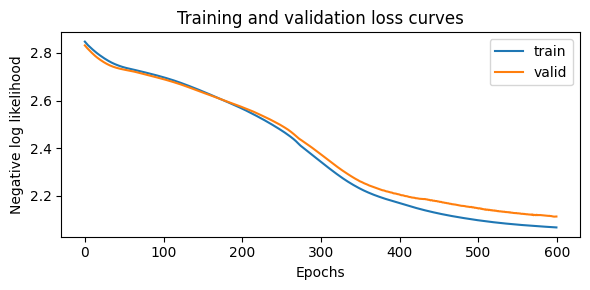

In [9]:
# Plot loss vs epoch
import matplotlib.pyplot as plt
# Get losses
train_losses = history.history['loss']
valid_losses = history.history['val_loss']

plt.figure(figsize=[6, 3])
plt.plot(train_losses, label='train')
plt.plot(valid_losses, label='valid')
plt.legend()
plt.xlabel(xlabel='Epochs')
plt.ylabel(ylabel='Negative log likelihood')
plt.title(label='Training and validation loss curves')
plt.tight_layout()
plt.show()

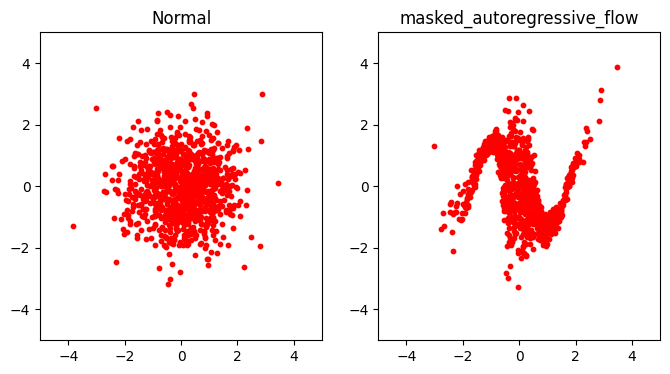

In [10]:
# Make samples
x = base_distribution.sample(sample_shape=[1000, 2])
names = [base_distribution.name, trainable_distribution.bijector.name]
samples = [x, trainable_distribution.bijector.forward(x=x)]

# Plot
_plot(results=samples, names=names)

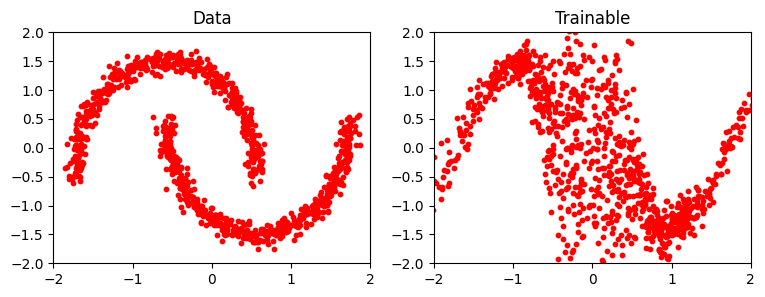

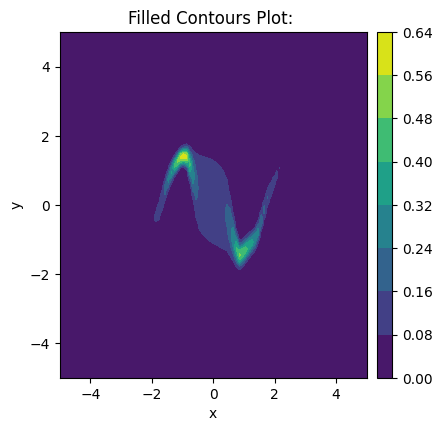

In [11]:
# Define a plot routine
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)
import matplotlib.pyplot as plt

def visualize_training_data(samples):
    f, arr = plt.subplots(nrows=1, ncols=2, figsize=(9, 3))
    names = ['Data', 'Trainable']
    samples = [tf.constant(value=X_data), samples[-1]]

    for i in range(2):
        res = samples[i]
        X, Y = res[..., 0].numpy(), res[..., 1].numpy()
        arr[i].scatter(x=X, y=Y, s=10, color='red')
        arr[i].set_xlim([-2, 2])
        arr[i].set_ylim([-2, 2])
        arr[i].set_title(label=names[i])

visualize_training_data(samples=samples)

# Plot contour
plot_contour_prob(dist=[trainable_distribution], scale_fig=5)

#### Training a chain of MaskedAutoregressiveFlow bijectors

In [12]:
# Define a more expressive model
import tensorflow as tf
import tensorflow_probability as tfp
tf.keras.utils.set_random_seed(seed=42)

num_bijectors = 6
bijectors = []

for i in range(num_bijectors):
    masked_auto_i = make_masked_autoregressive_flow(
        hidden_units=[256, 256], activation=tf.keras.activations.relu)
    bijectors.append(masked_auto_i)
    bijectors.append(tfp.bijectors.Permute(permutation=[1, 0]))

flow_bijector = tfp.bijectors.Chain(bijectors=list(reversed(bijectors[:-1])))
flow_bijector.bijectors

[<tfp.bijectors.MaskedAutoregressiveFlow 'masked_autoregressive_flow' batch_shape=[] forward_min_event_ndims=1 inverse_min_event_ndims=1 dtype_x=? dtype_y=?>,
 <tfp.bijectors.Permute 'permute' batch_shape=[] forward_min_event_ndims=1 inverse_min_event_ndims=1 dtype_x=? dtype_y=?>,
 <tfp.bijectors.MaskedAutoregressiveFlow 'masked_autoregressive_flow' batch_shape=[] forward_min_event_ndims=1 inverse_min_event_ndims=1 dtype_x=? dtype_y=?>,
 <tfp.bijectors.Permute 'permute' batch_shape=[] forward_min_event_ndims=1 inverse_min_event_ndims=1 dtype_x=? dtype_y=?>,
 <tfp.bijectors.MaskedAutoregressiveFlow 'masked_autoregressive_flow' batch_shape=[] forward_min_event_ndims=1 inverse_min_event_ndims=1 dtype_x=? dtype_y=?>,
 <tfp.bijectors.Permute 'permute' batch_shape=[] forward_min_event_ndims=1 inverse_min_event_ndims=1 dtype_x=? dtype_y=?>,
 <tfp.bijectors.MaskedAutoregressiveFlow 'masked_autoregressive_flow' batch_shape=[] forward_min_event_ndims=1 inverse_min_event_ndims=1 dtype_x=? dtype_y

In [13]:
# Define the trainable distribution
import tensorflow as tf
import tensorflow_probability as tfp
tf.keras.utils.set_random_seed(seed=42)

trainable_distribution = tfp.distributions.TransformedDistribution(
    distribution=tfp.distributions.Sample(distribution=base_distribution, sample_shape=2),
    bijector=flow_bijector)
trainable_distribution

<tfp.distributions._TransformedDistribution 'chain_of_masked_autoregressive_flow_of_permute_of_masked_autoregressive_flow_of_permute_of_masked_autoregressive_flow_of_permute_of_masked_autoregressive_flow_of_permute_of_masked_autoregressive_flow_of_permute_of_masked_autoregressive_flowSampleNormal' batch_shape=[] event_shape=[2] dtype=float32>

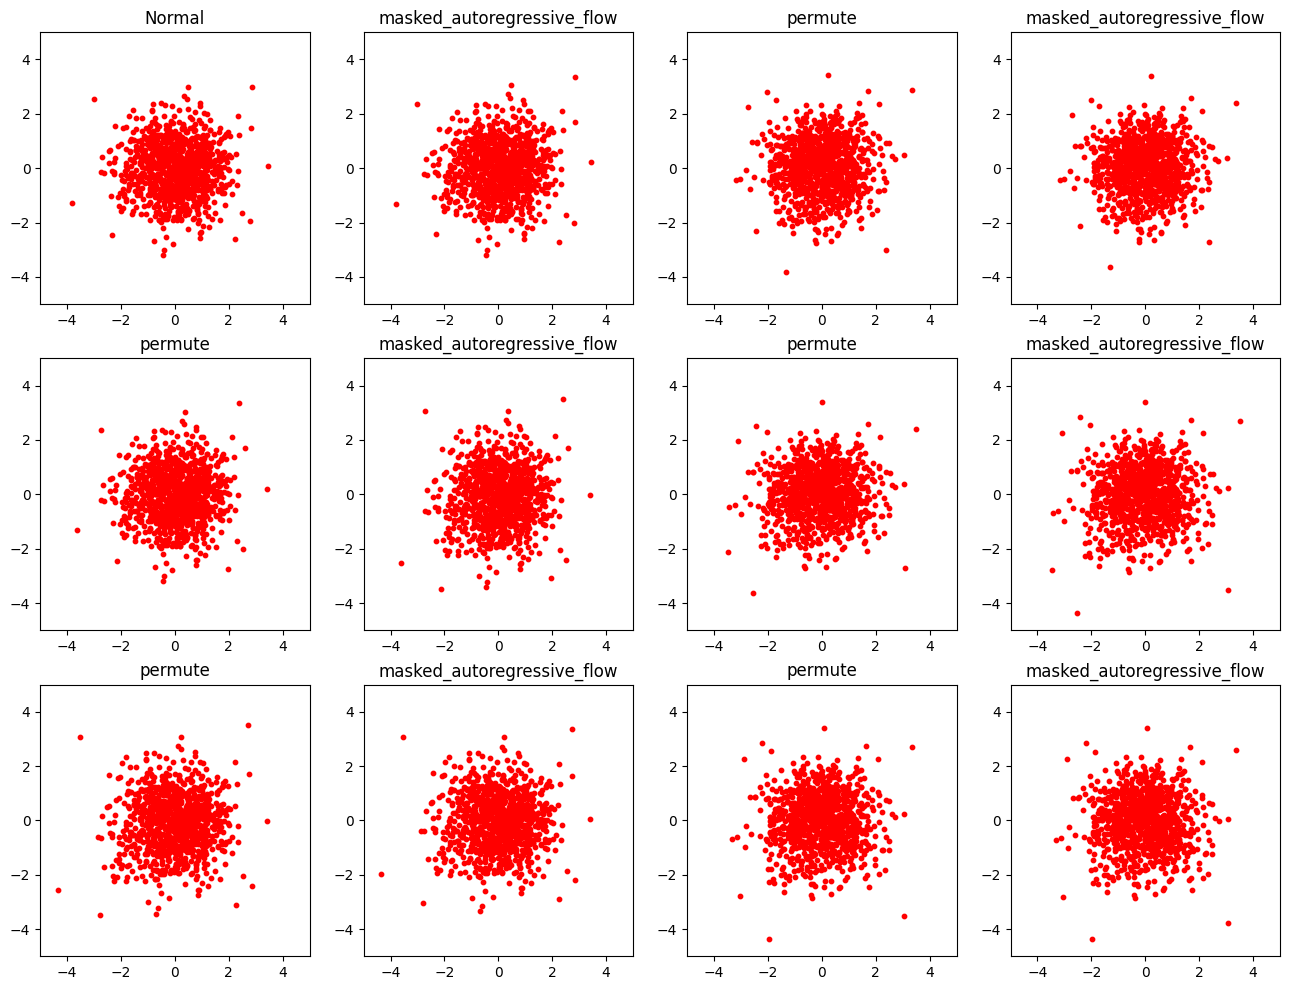

In [14]:
# Make samples
def make_samples():
    x = base_distribution.sample(sample_shape=(1000, 2))
    samples = [x]
    names = [base_distribution.name]
    for bijector in reversed(trainable_distribution.bijector.bijectors):
        x = bijector.forward(x=x)
        samples.append(x)
        names.append(bijector.name)
    return names, samples

names, samples = make_samples()
# Plot
_plot(results=samples, names=names, rows=3)

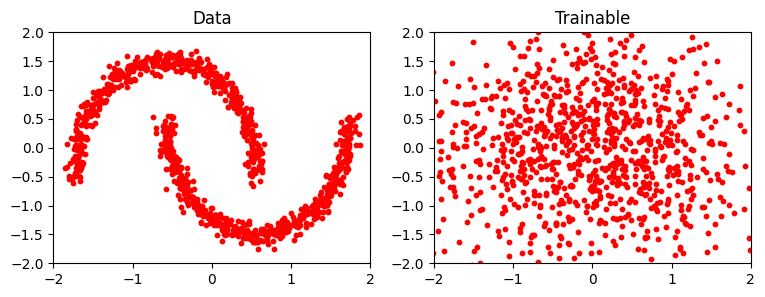

In [15]:
# Plot
visualize_training_data(samples=samples)

In [16]:
# Train the distribution
history = train_dist_routine(n_epochs=1000, n_disp=100,
    trainable_distribution=trainable_distribution)


 Epoch 1/1000 
	 loss: 2.8624, val_loss: 2.6647

 Epoch 101/1000 
	 loss: 1.9136, val_loss: 1.9849

 Epoch 201/1000 
	 loss: 2.4169, val_loss: 2.4766

 Epoch 301/1000 
	 loss: 1.6739, val_loss: 2.3261

 Epoch 401/1000 
	 loss: 1.7939, val_loss: 2.1836

 Epoch 501/1000 
	 loss: 1.4367, val_loss: 39.9104

 Epoch 601/1000 
	 loss: 1.2974, val_loss: 9.3246

 Epoch 701/1000 
	 loss: 1.2358, val_loss: 3.4006

 Epoch 801/1000 
	 loss: 1.1837, val_loss: 2.5525

 Epoch 901/1000 
	 loss: 1.1467, val_loss: 2.3636


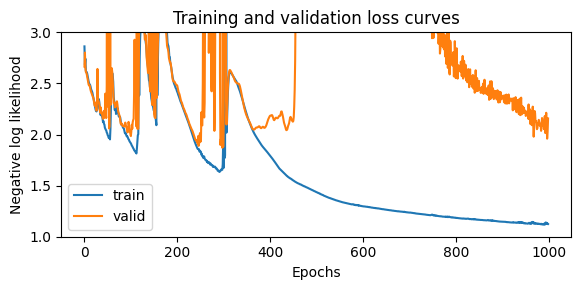

In [17]:
# Plot loss vs epoch
import matplotlib.pyplot as plt
# Get losses
train_losses = history.history['loss']
valid_losses = history.history['val_loss']

plt.figure(figsize=[6, 3])
plt.plot(train_losses, label='train')
plt.plot(valid_losses, label='valid')
plt.legend()
plt.xlabel(xlabel='Epochs')
plt.ylabel(ylabel='Negative log likelihood')
plt.title(label='Training and validation loss curves')
plt.ylim([1, 3])
plt.tight_layout()
plt.show()

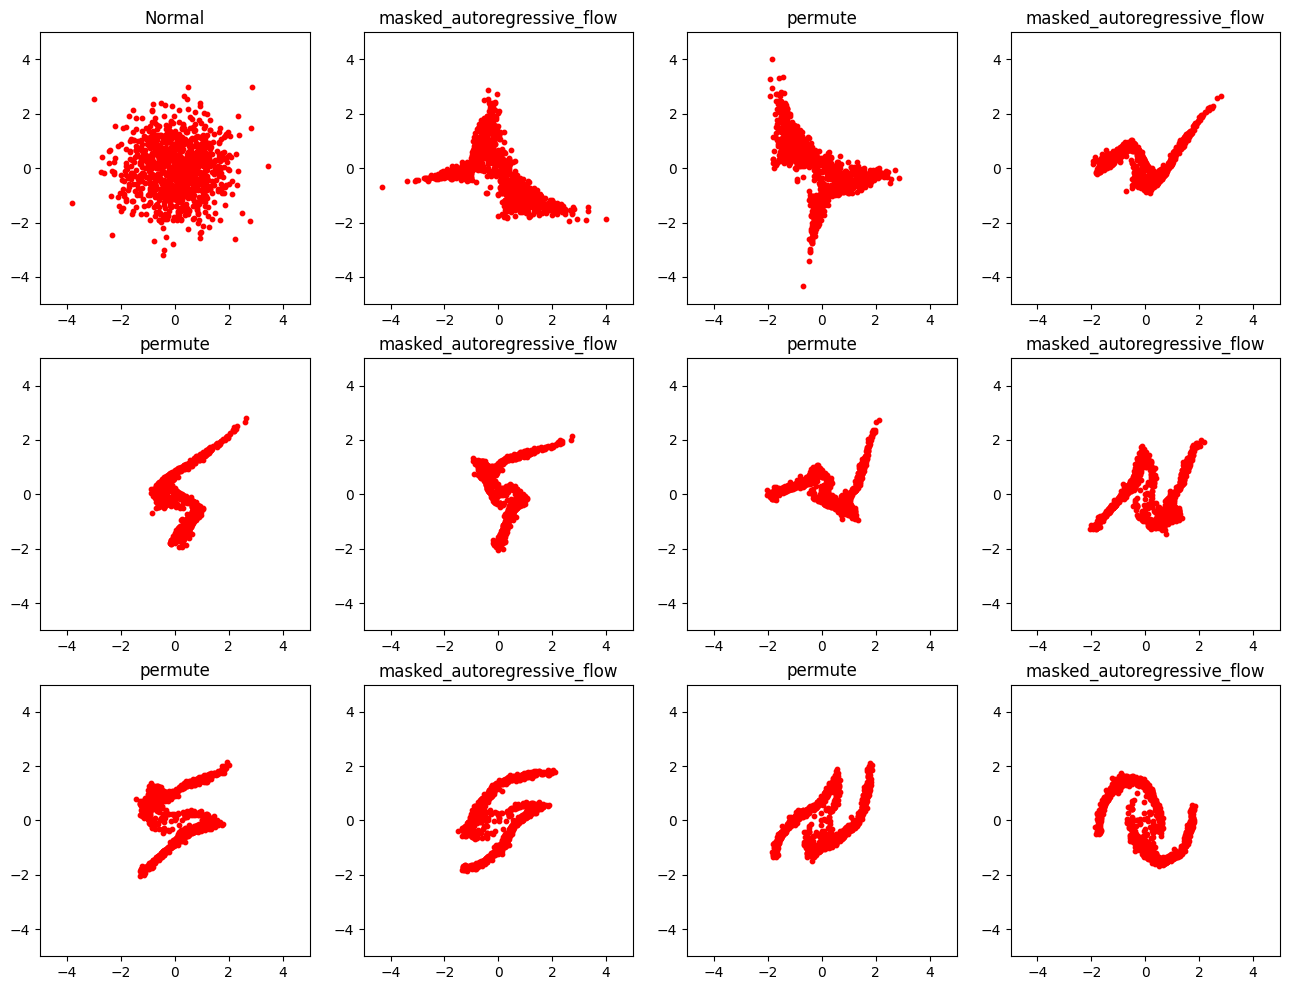

In [18]:
# Make samples and plot
names, samples = make_samples()
_plot(results=samples, names=names, rows=3)

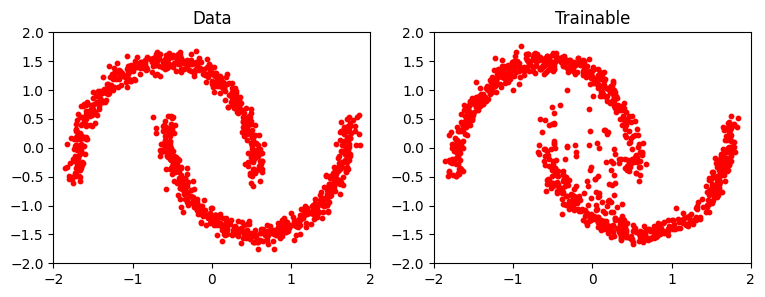

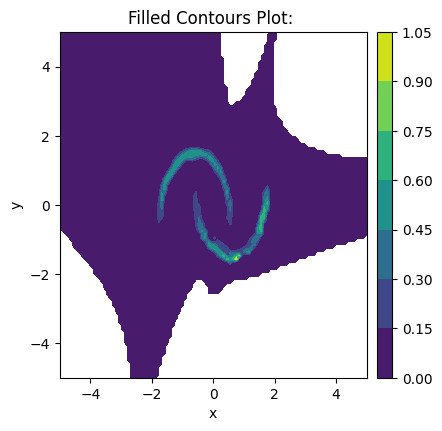

In [19]:
# Plot
visualize_training_data(samples=samples)
# Plot
plot_contour_prob(dist=[trainable_distribution], scale_fig=5)